# **EARLY LUNG CANCER DIAGNOSIS USING MULTI RISK FACTOR ANALYSIS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/lung cancer survey.csv')

# **Data Description**

The effectiveness of cancer prediction system helps the people to know their cancer risk with low cost and it also helps the people to take the appropriate decision based on their cancer risk status. The data is collected from the website online lung cancer prediction system .
Total no. of attributes:16
No .of instances:284
Attribute information:

>Gender: M(male), F(female) <br>
>Age: Age of the patient <br>
>Smoking: YES=2 , NO=1. <br>
>Yellow fingers: YES=2 , NO=1. <br>
>Anxiety: YES=2 , NO=1. <br>
>Peer_pressure: YES=2 , NO=1. <br>
>Chronic Disease: YES=2 , NO=1. <br>
>Fatigue: YES=2 , NO=1. <br>
>Allergy: YES=2 , NO=1. <br>
>Wheezing: YES=2 , NO=1. <br>
>Alcohol: YES=2 , NO=1. <br>
>Coughing: YES=2 , NO=1. <br>
>Shortness of Breath: YES=2 , NO=1. <br>
>Swallowing Difficulty: YES=2 , NO=1. <br>
>Chest pain: YES=2 , NO=1. <br>
>Lung Cancer: YES , NO. <br>

In [ ]:
dataset.shape

(309, 16)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GENDER                 309 non-null    int64  
 1   AGE                    309 non-null    float64
 2   SMOKING                309 non-null    int64  
 3   YELLOW_FINGERS         309 non-null    int64  
 4   ANXIETY                309 non-null    int64  
 5   PEER_PRESSURE          309 non-null    int64  
 6   CHRONIC DISEASE        309 non-null    int64  
 7   FATIGUE                309 non-null    int64  
 8   ALLERGY                309 non-null    int64  
 9   WHEEZING               309 non-null    int64  
 10  ALCOHOL CONSUMING      309 non-null    int64  
 11  COUGHING               309 non-null    int64  
 12  SHORTNESS OF BREATH    309 non-null    int64  
 13  SWALLOWING DIFFICULTY  309 non-null    int64  
 14  CHEST PAIN             309 non-null    int64  
 15  LUNG_C

# **Distribution of subcategory of each attribute**

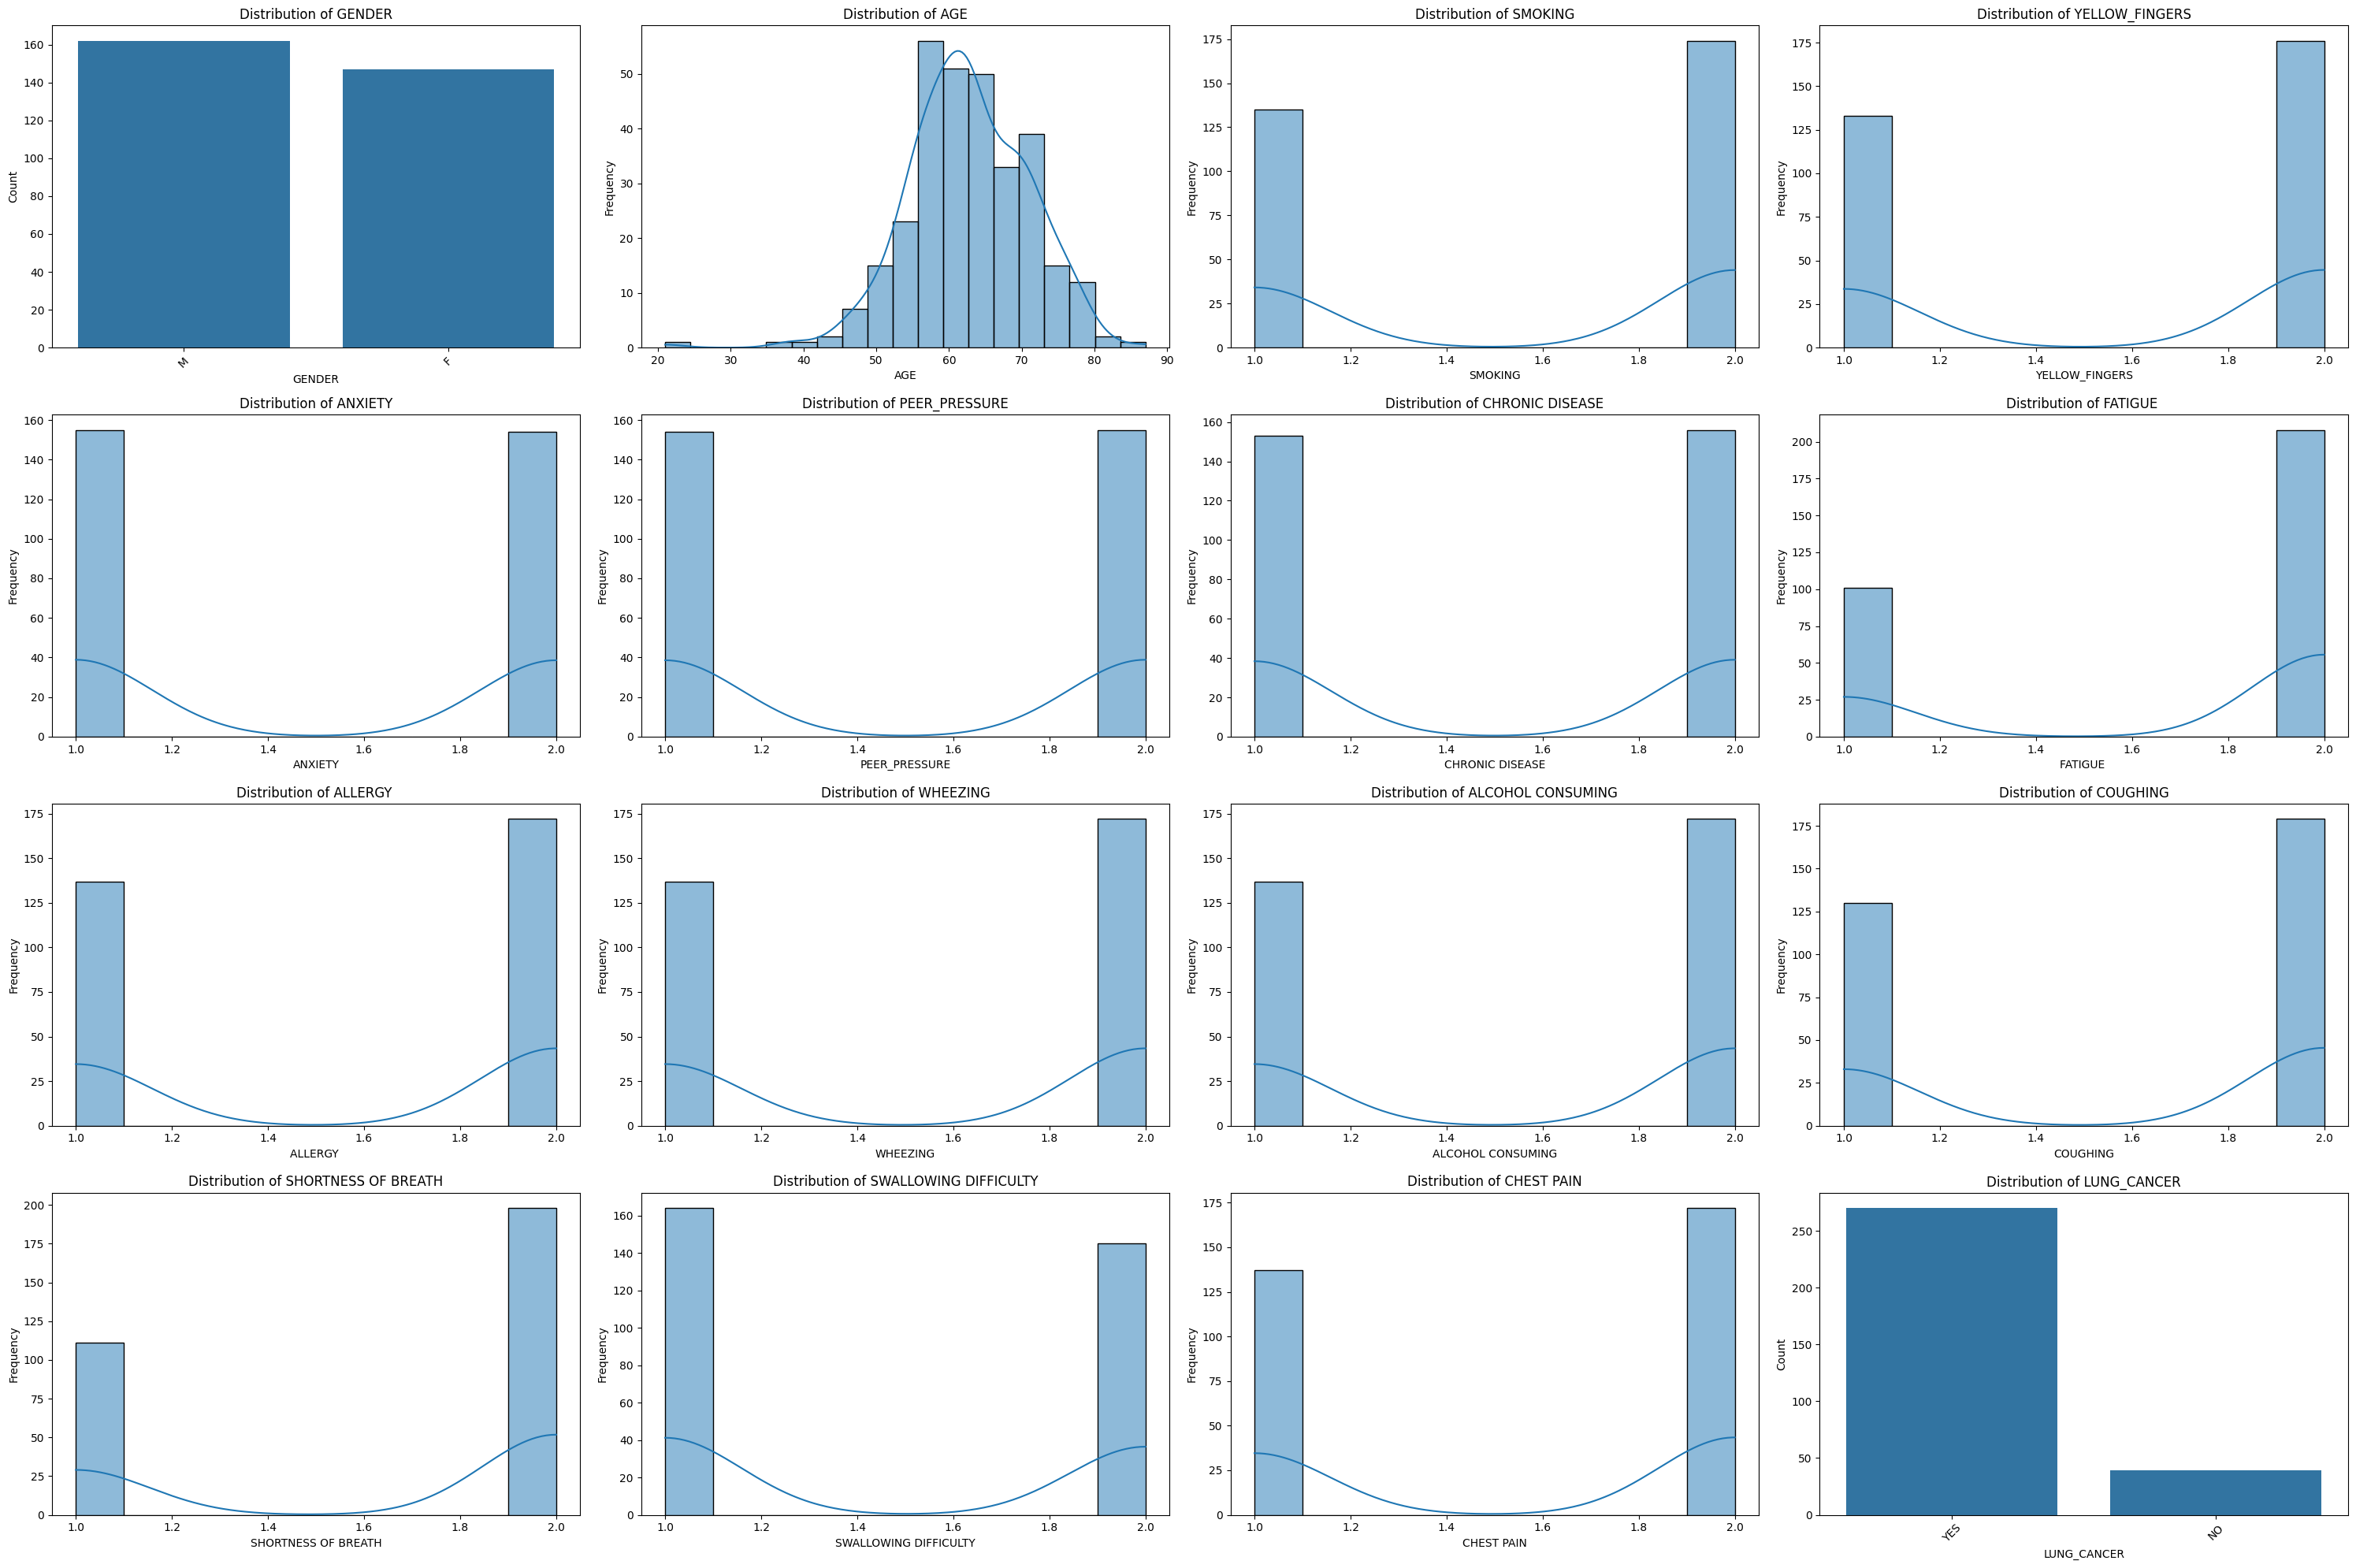

In [ ]:
num_cols = 4
num_rows = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

axes = axes.flatten()
plot_idx = 0

for column in dataset.columns:
    ax = axes[plot_idx]

    if dataset[column].dtype == 'object':
        sns.countplot(x=column, data=dataset, ax=ax)  # Plot count plot on the specific subplot
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for clarity
    else:  # If column is numerical
        sns.histplot(dataset[column], kde=True, ax=ax)  # Histogram with KDE
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plot_idx += 1

# Remove any extra subplots if there are fewer columns than grid spaces
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to minimize overlap
plt.tight_layout()
plt.show()

**Checking if the dataset is balanced**

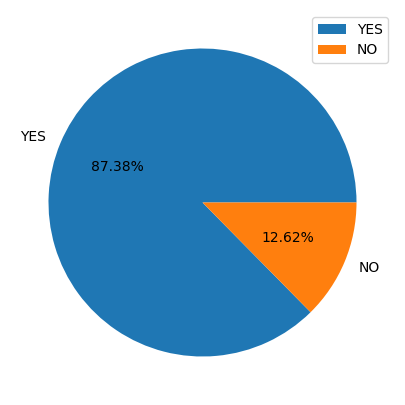

In [ ]:
tdf = dataset['LUNG_CANCER'].value_counts().reset_index()
plt.figure(figsize=(15,5))
plt.pie(x=tdf['count'],labels=tdf['LUNG_CANCER'],autopct='%.2f%%')
plt.legend(tdf['LUNG_CANCER'])
plt.show()

>*The dataset is imbalanced*

# **Data Preprocessing**

Encoding gender and target

In [ ]:
dataset['GENDER'] = dataset['GENDER'].map({'F': 0, 'M': 1})
dataset['LUNG_CANCER'] = dataset['LUNG_CANCER'].map({'NO': 0, 'YES': 1})

Scaling the age

In [ ]:
scaler = MinMaxScaler()
num_vars= ['AGE']
dataset[num_vars]=scaler.fit_transform(dataset[num_vars])

Correlation analysis

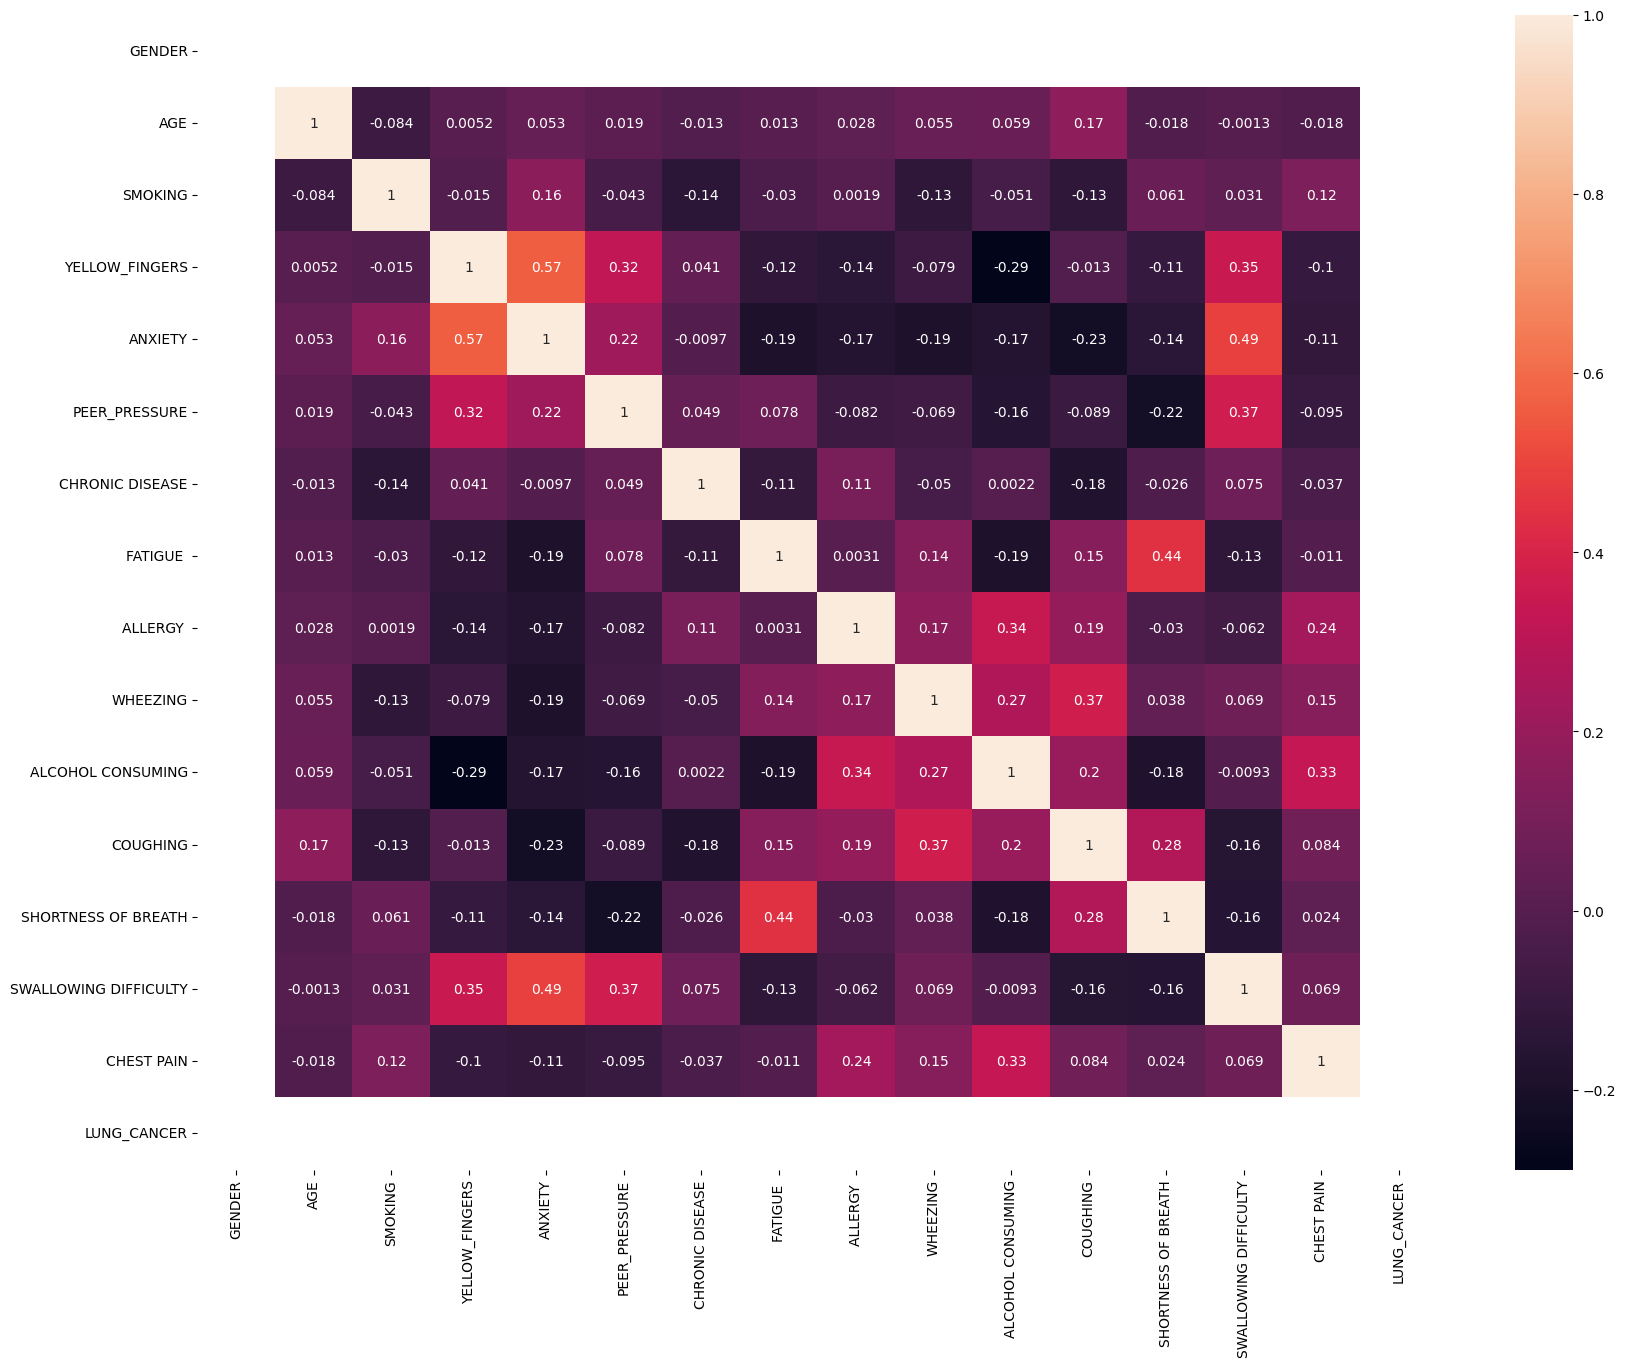

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(dataset.corr(),annot=True,cbar='magma')
plt.show()

Separating features and targets

In [ ]:
from sklearn.model_selection import train_test_split

X = dataset.drop('LUNG_CANCER', axis=1)
y = dataset['LUNG_CANCER']

X.shape, y.shape

((309, 15), (309,))

**Calculating the mutual information of each attribute**

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False).reset_index(drop=True)

In [ ]:
print(mi_df)

                  Feature  Mutual Information
0                ALLERGY             0.048365
1   SWALLOWING DIFFICULTY            0.043417
2                 ANXIETY            0.037374
3                COUGHING            0.035186
4                     AGE            0.034622
5       ALCOHOL CONSUMING            0.033856
6          YELLOW_FINGERS            0.028435
7           PEER_PRESSURE            0.025918
8                WHEEZING            0.022194
9              CHEST PAIN            0.009612
10               FATIGUE             0.008323
11    SHORTNESS OF BREATH            0.007026
12        CHRONIC DISEASE            0.006781
13                 GENDER            0.006065
14                SMOKING            0.000000


# **Mutual information of Risk factors**

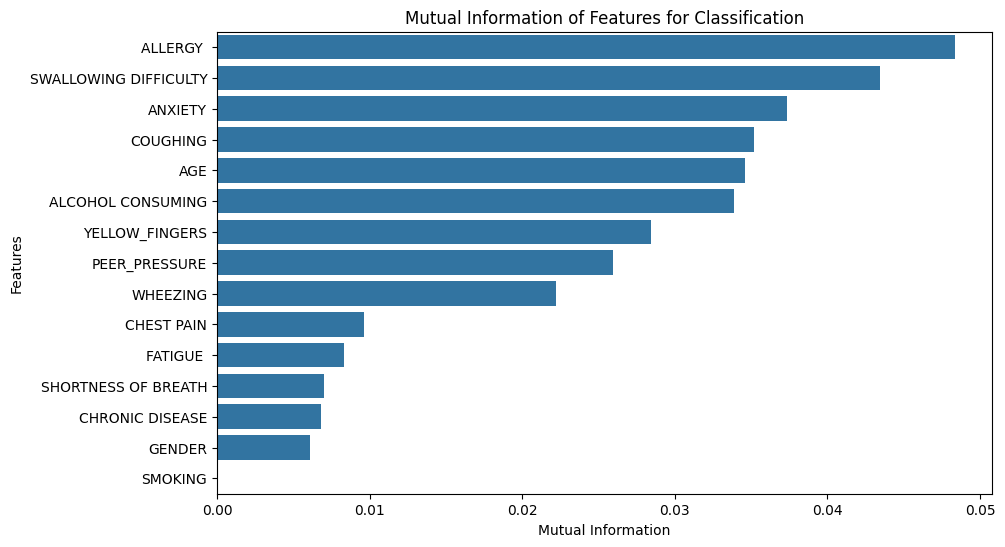

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='Mutual Information',y='Feature', data=mi_df)
plt.title('Mutual Information of Features for Classification')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

Balancing the dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler

over_samp = RandomOverSampler(random_state=0)
X_ros, y_ros = over_samp.fit_resample(X, y)
X_ros.shape, y_ros.shape

((540, 15), (540,))

Visualizing the balanced dataset

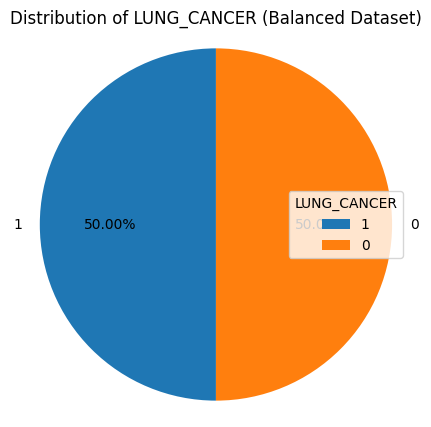

In [ ]:
tdf = pd.Series(y_ros).value_counts().reset_index()
tdf.columns = ['LUNG_CANCER', 'count']  # Rename columns for clarity

# Plotting the pie chart
plt.figure(figsize=(5, 5))  # Adjust the figure size for better visibility
plt.pie(x=tdf['count'], labels=tdf['LUNG_CANCER'], autopct='%.2f%%', startangle=90)
plt.title('Distribution of LUNG_CANCER (Balanced Dataset)')
plt.axis('equal')  # Ensures that the pie is a circle
plt.legend(title='LUNG_CANCER', loc='best')
plt.show()

Splitting dataset into - 75% training and 25% -testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train , y_test = train_test_split(X_ros, y_ros, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((405, 15), (135, 15), (405,), (135,))

# **BASELINE MODEL DEVELOPMENT**

# KNN Classifier

In [ ]:
knn = KNeighborsClassifier()
params = {'n_neighbors':list(np.arange(2,50))}
nknn = RandomizedSearchCV(knn, n_jobs=-1, random_state=20, scoring='accuracy', param_distributions=params,cv=10) #Finding Best K
nknn.fit(X_train, y_train)
print(nknn.best_params_)
print(nknn.best_score_)
nknn = nknn.best_estimator_

{'n_neighbors': 3}
0.9334756097560974


Classification report for KNN Classifier

In [ ]:
cm_t=[] #To store confusion matrices for training set
cm=[] #To store confusion matrices for training set
pred_t = nknn.predict(X_train)  #Predicting on the training set
pred=nknn.predict(X_test)  #Predicting on the testing set
print('KNN Training Accuracy: ', accuracy_score(y_train, pred_t))
print('KNN Testing Accuracy: ', accuracy_score(y_test,pred))
print('\nClassification Report for KNN Classifier:\n\n ',classification_report(y_test,pred))
cmk_t = confusion_matrix(y_train,pred_t)
cm_t.append(cmk_t)
cmk = confusion_matrix(y_test,pred)
cm.append(cmk)

KNN Training Accuracy:  0.9604938271604938
KNN Testing Accuracy:  0.9629629629629629

Classification Report for KNN Classifier:

                precision    recall  f1-score   support

           0       0.93      1.00      0.96        66
           1       1.00      0.93      0.96        69

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.97      0.96      0.96       135



# Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
path = dt.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas
params = {'ccp_alpha':alphas}
ndt = GridSearchCV(dt,param_grid=params,n_jobs=-1,scoring='accuracy',cv=10)  # Finding Best Alpha
ndt.fit(X_train, y_train)
print(ndt.best_params_)
print(ndt.best_score_)
best_alpha = ndt.best_params_['ccp_alpha']

{'ccp_alpha': 0.0}
0.9606097560975609


In [ ]:
dt=DecisionTreeClassifier(ccp_alpha=best_alpha)
# Hyper Parameter Tuning -> We can use more parameters
params= {'criterion':['gini','entropy'],'min_samples_split':list(np.arange(2,51)),'min_samples_leaf':list(np.arange(2,51)),
        'max_features':['sqrt','log2',None]}
ndt=RandomizedSearchCV(dt,param_distributions=params,scoring='accuracy',random_state=42,n_jobs=-1,cv=10)
ndt.fit(X_train, y_train)
print(ndt.best_params_)
print(ndt.best_score_)
ndt=ndt.best_estimator_

{'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}
0.8695731707317073


**Classification report for decision tree classifier**

In [ ]:
pred1_t = ndt.predict(X_train)
pred1 = ndt.predict(X_test)
print('Decision Tree Classifier Training Accuracy: ', accuracy_score(y_train,pred1_t))
print('Decision Tree Classifier Testing Accuracy: ', accuracy_score(y_test,pred1))
print('\nClassification Report for Decision Tree Classifier Classifier:\n\n ', classification_report(y_test,pred1))
cmdt_t = confusion_matrix(y_train, pred1_t)
cm_t.append(cmdt_t)
cmdt = confusion_matrix(y_test, pred1)
cm.append(cmdt)

Decision Tree Classifier Training Accuracy:  0.9037037037037037
Decision Tree Classifier Testing Accuracy:  0.9111111111111111

Classification Report for Decision Tree Classifier Classifier:

                precision    recall  f1-score   support

           0       0.85      1.00      0.92        66
           1       1.00      0.83      0.90        69

    accuracy                           0.91       135
   macro avg       0.92      0.91      0.91       135
weighted avg       0.92      0.91      0.91       135



# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
params = {'criterion':['gini','entropy'],'min_samples_split':list(np.arange(2,41)),'min_samples_leaf':list(np.arange(2,41)),
        'max_features':['sqrt','log2',None],'n_estimators':[1000]}
nrf = RandomizedSearchCV(rf,param_distributions=params,scoring='accuracy',random_state=42,n_jobs=-1,cv=10)
nrf.fit(X_train, y_train)
print(nrf.best_params_)
print(nrf.best_score_)
nrf = nrf.best_estimator_

{'n_estimators': 1000, 'min_samples_split': 27, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'entropy'}
0.911158536585366


**Classification report for random forest classifier**

In [ ]:
pred2_t = nrf.predict(X_train)
pred2 =  nrf.predict(X_test)  #Predicting on the testing set
print('Random Forest Classifier Training Accuracy: ',accuracy_score(y_train, pred2_t))
print('Random Forest Classifier Testing Accuracy: ',accuracy_score(y_test, pred2))
print('\nClassification Report for Random Forest Classifier Classifier:\n\n ',classification_report(y_test, pred2))
cmrf_t = confusion_matrix(y_train, pred2_t)
cm_t.append(cmrf_t)
cmrf = confusion_matrix(y_test, pred2)
cm.append(cmrf)

Random Forest Classifier Training Accuracy:  0.9407407407407408
Random Forest Classifier Testing Accuracy:  0.9185185185185185

Classification Report for Random Forest Classifier Classifier:

                precision    recall  f1-score   support

           0       0.91      0.92      0.92        66
           1       0.93      0.91      0.92        69

    accuracy                           0.92       135
   macro avg       0.92      0.92      0.92       135
weighted avg       0.92      0.92      0.92       135



# AdaBoost Classifier

In [ ]:
ada = AdaBoostClassifier(algorithm='SAMME')
params = {
    'n_estimators': [300],
    'learning_rate': np.arange(0.01, 2.01, 0.01),}

nada = RandomizedSearchCV(ada,param_distributions=params,cv=10,n_jobs=-1,scoring='accuracy')
nada.fit(X_train, y_train)
print(nada.best_params_)
print(nada.best_score_)
nada=nada.best_estimator_

{'n_estimators': 300, 'learning_rate': 1.1600000000000001}
0.9285975609756099


**Classification report for adaBoost classifier**

In [ ]:
pred3_t = nada.predict(X_train)
pred3 = nada.predict(X_test)
print('AdaBoost Classifier Training Accuracy: ',accuracy_score(y_train,pred3_t))
print('Adaboost Classifier Testing Accuracy: ',accuracy_score(y_test,pred3))
print('\nClassification Report for Random Forest Classifier Classifier:\n\n ', classification_report(y_test, pred2))
cmada_t = confusion_matrix(y_train, pred3_t)
cm_t.append(cmada_t)
cmada = confusion_matrix(y_test, pred3)
cm.append(cmada)

AdaBoost Classifier Training Accuracy:  0.9530864197530864
Adaboost Classifier Testing Accuracy:  0.9481481481481482

Classification Report for Random Forest Classifier Classifier:

                precision    recall  f1-score   support

           0       0.91      0.92      0.92        66
           1       0.93      0.91      0.92        69

    accuracy                           0.92       135
   macro avg       0.92      0.92      0.92       135
weighted avg       0.92      0.92      0.92       135



# ANN Classifier

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4832 - loss: 0.7325 - val_accuracy: 0.6173 - val_loss: 0.6759
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6152 - loss: 0.6820 - val_accuracy: 0.5679 - val_loss: 0.6712
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6019 - loss: 0.6664 - val_accuracy: 0.6173 - val_loss: 0.6533
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6182 - loss: 0.6488 - val_accuracy: 0.6296 - val_loss: 0.6518
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6568 - loss: 0.6329 - val_accuracy: 0.6296 - val_loss: 0.6397
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6380 - loss: 0.6167 - val_accuracy: 0.6296 - val_loss: 0.6386
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6622 - loss: 0.6073 - val_accuracy: 0.6173 - val_loss: 0.6287
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6516 - loss: 0.6233 - val_accuracy: 0.6420 - val_loss: 0.6244
Ep

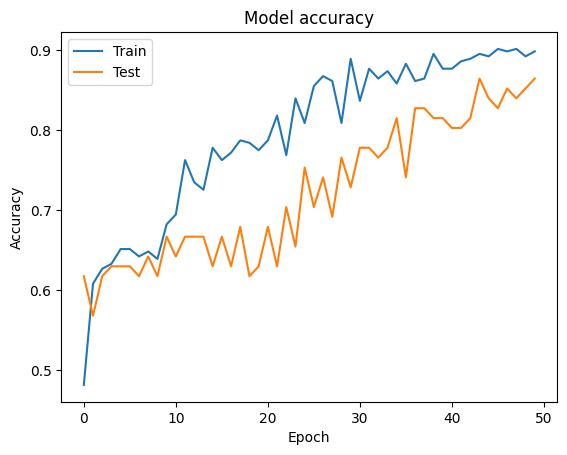

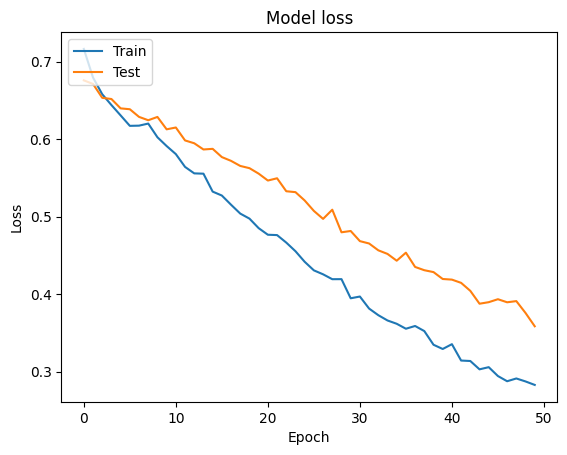

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_t_pred = (model.predict(X_train) > 0.5).astype("int32")

cmada_t = confusion_matrix(y_train, y_t_pred)
cm_t.append(cmada_t)
cmada = confusion_matrix(y_test, y_pred)
cm.append(cmada)

# Print classification report
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Visualizing the combined confusion matrices**

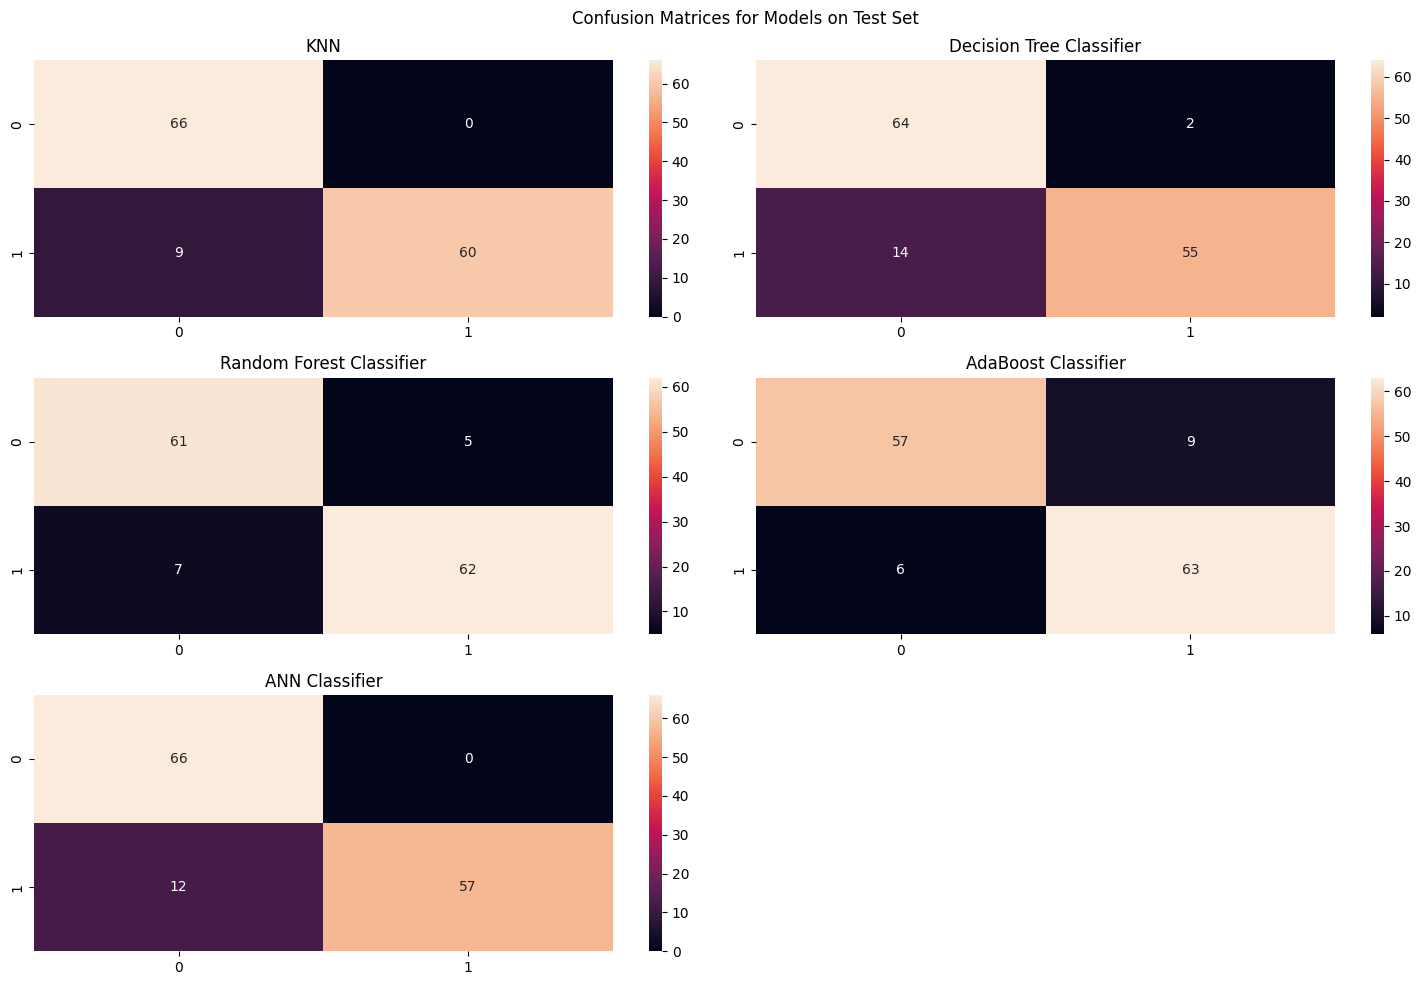

In [ ]:
mods = ['KNN','Decision Tree Classifier','Random Forest Classifier','AdaBoost Classifier', 'ANN Classifier']

fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax = ax.flatten()

for i, mod in enumerate(mods):
    sns.heatmap(cm[i], annot=True, fmt='d', ax=ax[i])  # Use ax[i] to access subplots sequentially
    ax[i].set_title(mod)

for j in range(len(mods), len(ax)):
    fig.delaxes(ax[j])

plt.suptitle('Confusion Matrices for Models on Test Set')
plt.tight_layout()
plt.show()

# **Feature Extraction**

Dropping the less correlated attributes

In [ ]:
X_ros_features = X_ros.drop(['GENDER', 'SMOKING', 'CHRONIC DISEASE', 'SHORTNESS OF BREATH', 'CHEST PAIN'], axis = 1)
X_ros_features = X_ros_features.drop(X_ros_features.columns[4], axis=1)

Splitting dataset 75% - training and 25% -dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train , y_test = train_test_split(X_ros_features, y_ros, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((405, 9), (135, 9), (405,), (135,))

# KNN Classifier

In [ ]:
knn = KNeighborsClassifier()
params = {'n_neighbors':list(np.arange(2,50))}
nknn = RandomizedSearchCV(knn, n_jobs=-1, random_state=20, scoring='accuracy', param_distributions=params,cv=10) #Finding Best K
nknn.fit(X_train, y_train)
print(nknn.best_params_)
print(nknn.best_score_)
nknn = nknn.best_estimator_

{'n_neighbors': 3}
0.9285365853658536


Classification report for KNN Classifier

In [ ]:
cm_t=[] #To store confusion matrices for training set
cm=[] #To store confusion matrices for training set
pred_t = nknn.predict(X_train)  #Predicting on the training set
pred=nknn.predict(X_test)  #Predicting on the testing set
print('KNN Training Accuracy: ', accuracy_score(y_train, pred_t))
print('KNN Testing Accuracy: ', accuracy_score(y_test,pred))
print('\nClassification Report for KNN Classifier:\n\n ',classification_report(y_test,pred))
cmk_t = confusion_matrix(y_train,pred_t)
cm_t.append(cmk_t)
cmk = confusion_matrix(y_test,pred)
cm.append(cmk)

KNN Training Accuracy:  0.9555555555555556
KNN Testing Accuracy:  0.9333333333333333

Classification Report for KNN Classifier:

                precision    recall  f1-score   support

           0       0.88      1.00      0.94        66
           1       1.00      0.87      0.93        69

    accuracy                           0.93       135
   macro avg       0.94      0.93      0.93       135
weighted avg       0.94      0.93      0.93       135



# Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
path = dt.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas
params = {'ccp_alpha':alphas}
ndt = GridSearchCV(dt,param_grid=params,n_jobs=-1,scoring='accuracy',cv=10)  # Finding Best Alpha
ndt.fit(X_train, y_train)
print(ndt.best_params_)
print(ndt.best_score_)
best_alpha = ndt.best_params_['ccp_alpha']

{'ccp_alpha': 0.0}
0.9360365853658538


In [ ]:
dt=DecisionTreeClassifier(ccp_alpha=best_alpha)
# Hyper Parameter Tuning -> We can use more parameters
params= {'criterion':['gini','entropy'],'min_samples_split':list(np.arange(2,51)),'min_samples_leaf':list(np.arange(2,51)),
        'max_features':['sqrt','log2',None]}
ndt=RandomizedSearchCV(dt,param_distributions=params,scoring='accuracy',random_state=42,n_jobs=-1,cv=10)
ndt.fit(X_train, y_train)
print(ndt.best_params_)
print(ndt.best_score_)
ndt=ndt.best_estimator_

{'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}
0.8567682926829268


**Classification report for decision tree classifier**

In [ ]:
pred1_t = ndt.predict(X_train)
pred1 = ndt.predict(X_test)
print('Decision Tree Classifier Training Accuracy: ', accuracy_score(y_train,pred1_t))
print('Decision Tree Classifier Testing Accuracy: ', accuracy_score(y_test,pred1))
print('\nClassification Report for Decision Tree Classifier Classifier:\n\n ', classification_report(y_test,pred1))
cmdt_t = confusion_matrix(y_train, pred1_t)
cm_t.append(cmdt_t)
cmdt = confusion_matrix(y_test, pred1)
cm.append(cmdt)

Decision Tree Classifier Training Accuracy:  0.8790123456790123
Decision Tree Classifier Testing Accuracy:  0.8814814814814815

Classification Report for Decision Tree Classifier Classifier:

                precision    recall  f1-score   support

           0       0.82      0.97      0.89        66
           1       0.96      0.80      0.87        69

    accuracy                           0.88       135
   macro avg       0.89      0.88      0.88       135
weighted avg       0.89      0.88      0.88       135



# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
params = {'criterion':['gini','entropy'],'min_samples_split':list(np.arange(2,41)),'min_samples_leaf':list(np.arange(2,41)),
        'max_features':['sqrt','log2',None],'n_estimators':[1000]}
nrf = RandomizedSearchCV(rf,param_distributions=params,scoring='accuracy',random_state=42,n_jobs=-1,cv=10)
nrf.fit(X_train, y_train)
print(nrf.best_params_)
print(nrf.best_score_)
nrf = nrf.best_estimator_

{'n_estimators': 1000, 'min_samples_split': 27, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'entropy'}
0.8839024390243904


**Classification report for random forest classifier**

In [ ]:
pred2_t = nrf.predict(X_train)
pred2 =  nrf.predict(X_test)  #Predicting on the testing set
print('Random Forest Classifier Training Accuracy: ',accuracy_score(y_train, pred2_t))
print('Random Forest Classifier Testing Accuracy: ',accuracy_score(y_test, pred2))
print('\nClassification Report for Random Forest Classifier Classifier:\n\n ',classification_report(y_test, pred2))
cmrf_t = confusion_matrix(y_train, pred2_t)
cm_t.append(cmrf_t)
cmrf = confusion_matrix(y_test, pred2)
cm.append(cmrf)

Random Forest Classifier Training Accuracy:  0.9185185185185185
Random Forest Classifier Testing Accuracy:  0.9111111111111111

Classification Report for Random Forest Classifier Classifier:

                precision    recall  f1-score   support

           0       0.90      0.92      0.91        66
           1       0.93      0.90      0.91        69

    accuracy                           0.91       135
   macro avg       0.91      0.91      0.91       135
weighted avg       0.91      0.91      0.91       135



# AdaBoost Classifier

In [ ]:
ada = AdaBoostClassifier(algorithm='SAMME')
params = {
    'n_estimators': [300],
    'learning_rate': np.arange(0.01, 2.01, 0.01),}

nada = RandomizedSearchCV(ada,param_distributions=params,cv=10,n_jobs=-1,scoring='accuracy')
nada.fit(X_train, y_train)
print(nada.best_params_)
print(nada.best_score_)
nada=nada.best_estimator_

{'n_estimators': 300, 'learning_rate': 1.73}
0.9037195121951219


**Classification report for adaBoost classifier**

In [ ]:
pred3_t = nada.predict(X_train)
pred3 = nada.predict(X_test)
print('AdaBoost Classifier Training Accuracy: ',accuracy_score(y_train,pred3_t))
print('Adaboost Classifier Testing Accuracy: ',accuracy_score(y_test,pred3))
print('\nClassification Report for Random Forest Classifier Classifier:\n\n ', classification_report(y_test, pred2))
cmada_t = confusion_matrix(y_train, pred3_t)
cm_t.append(cmada_t)
cmada = confusion_matrix(y_test, pred3)
cm.append(cmada)

AdaBoost Classifier Training Accuracy:  0.9234567901234568
Adaboost Classifier Testing Accuracy:  0.8888888888888888

Classification Report for Random Forest Classifier Classifier:

                precision    recall  f1-score   support

           0       0.90      0.92      0.91        66
           1       0.93      0.90      0.91        69

    accuracy                           0.91       135
   macro avg       0.91      0.91      0.91       135
weighted avg       0.91      0.91      0.91       135



# ANN Classifier

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4993 - loss: 0.7118 - val_accuracy: 0.4815 - val_loss: 0.6855
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5498 - loss: 0.6704 - val_accuracy: 0.5926 - val_loss: 0.6735
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6139 - loss: 0.6624 - val_accuracy: 0.5679 - val_loss: 0.6679
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5851 - loss: 0.6523 - val_accuracy: 0.5679 - val_loss: 0.6628
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6086 - loss: 0.6550 - val_accuracy: 0.5432 - val_loss: 0.6559
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6286 - loss: 0.6338 - val_accuracy: 0.5309 - val_loss: 0.6538
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6912 - loss: 0.6316 - val_accuracy: 0.7037 - val_loss: 0.6423
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7345 - loss: 0.6203 - val_accuracy: 0.6173 - val_loss: 0.6445
Ep

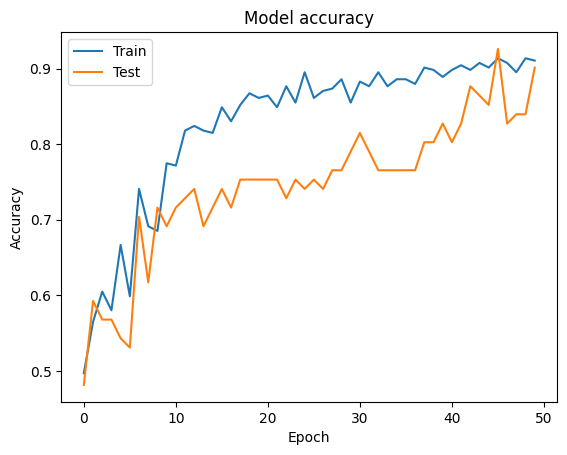

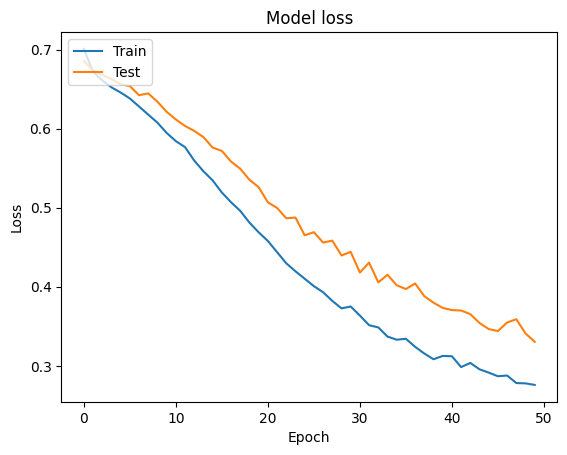

In [ ]:

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()